# PIE AQM implementation in P4

This notebook describes initial evaluation results of P4 PIE considering a single 1.5 Mbps bottleneck link shared among TCP flows. The target delay was set to 20 ms while the drop probability is updated in every 30 ms.

In [84]:
%matplotlib inline
import matplotlib.pyplot as ply
import pandas as pd
import numpy as np
import math
import matplotlib

## Configuration settings

In [152]:
NSDIR='c:\\users\\laki\\ns-3.29'
FIGSIZE=(8,2)
FIGSIZE2=(12,4)

## Comparison of NS-3 PIE and P4 PIE implementations

This scenario uses the qdisc-congestion scenario with testNumber=1,3,4.
The PIE parameters including target delay were the same in both cases.

In [108]:
rename_map = {'p4' : 'P4 PIE', 'pie' : 'NS-3 PIE'}

def plot_throughput(methods, reference, simlen):
    ply.figure(figsize=FIGSIZE)
    for m in methods:
        df = pd.read_csv(NSDIR + '\\' + m + '\\' + m + '-throughput.plotme',sep='\t', names=['ts', 'throughput'] )
        ply.plot(df.ts.values, df.throughput.values, linestyle="--", linewidth=2, label=rename_map[m])
    ply.axhline(reference, color='black', linestyle=':', linewidth=1.5, label='%.1f Mbps' % reference)
    ply.ylim(0,reference*1.1)
    ply.xlim(0,simlen)
    ply.ylabel("Throughput [Mbps]")
    ply.xlabel("Time [s]")
    ply.legend()
    ply.grid()
    ply.show()

def plot_inst_qsize(methods, reference_sec, bnrate_mbps, simlen):
    ply.figure(figsize=FIGSIZE)
    for m in methods:
        df = pd.read_csv(NSDIR + '\\' + m + '\\' + m + '-inst-qsize.plotme',sep='\t', names=['ts', 'qsize'] )
        ply.scatter(df.ts.values, df.qsize.values/1000, 0.5, label=rename_map[m])
    ply.axhline(reference_sec*bnrate_mbps*1e3/8, color='black', linestyle=':', linewidth=1.5, label='%d ms @ %.1f Mbps' % (reference_sec*1000, bnrate_mbps))
    ply.ylim(0)
    ply.xlim(0,simlen)
    ply.ylabel("Queue Size [KBytes]")
    ply.xlabel("Time [s]")
    ply.legend()
    ply.grid()
    ply.show()

def plot_drop_times(methods, bins, simlen):
    ply.figure(figsize=FIGSIZE)
    for m in methods:
        df = pd.read_csv(NSDIR + '\\' + m + '\\' + m + '-drop-times.plotme',sep=' ', names=['ts', 'dummy'] )
        df.ts.hist(bins=bins, rwidth=0.85, alpha=0.5, label=rename_map[m])       
    ply.ylim(0)
    ply.xlim(0,simlen)
    ply.ylabel("#drops")
    ply.xlabel("Time [s]")
    ply.legend()
    ply.show()  

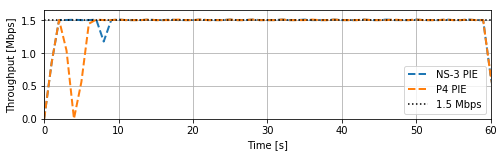

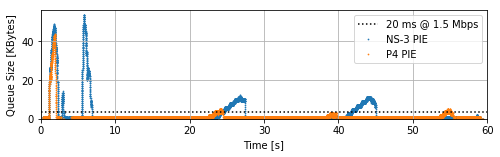

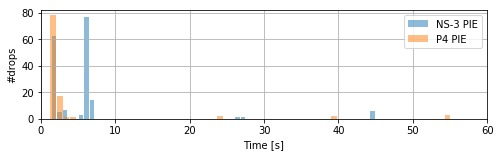

In [109]:
plot_throughput(['pie','p4'], 1.5, 60)
plot_inst_qsize(['pie','p4'], 0.02, 1.5, 60) # target delay = 20 ms, bn=1.5 Mbps
plot_drop_times(['pie','p4'], 60, 60)

## P4 PIE behaviour

In [170]:
def plot_drop_times_prob(methods, bins, simlen):
    ply.figure(figsize=FIGSIZE2)
    for m in methods:
        df = pd.read_csv(NSDIR + '\\' + m + '\\' + m + '-drop-times.plotme',sep=' ', names=['ts', 'dummy'] )
        df.ts.hist(bins=bins, rwidth=0.85, alpha=0.5, label='%s - #Drops' % rename_map[m])
    for m in methods:
        df = pd.read_csv(NSDIR + '\\' + m + '\\' + m + '-drop-prob.plotme',sep='\t', names=['ts', 'prob'] )
        ply.step(df.ts.values, df.prob.values/(2**32/100), where='pre', linewidth=2, label="%s - Drop prob. (0-100%%)" % rename_map[m])
    ply.ylim(0)
    ply.xlim(0,simlen)
    ply.ylabel("On the legend")
    ply.xlabel("Time [s]")
    ply.legend()
    ply.show()

def plot_qdelay_drop_prob(methods, simlen):
    fig, ax1 = ply.subplots(figsize=FIGSIZE2)
    for m in methods:
        df = pd.read_csv(NSDIR + '\\' + m + '\\' + m + '-qlatency.plotme',sep='\t', names=['ts', 'qdelay'] )
        ax1.step(df.ts.values, df.qdelay.values/(10**6), 'b-', where='pre', linewidth=3, label="%s - Qlatency [ms]" % rename_map[m])
    ax1.set_xlabel("Time [s]")
    ax1.set_ylabel("Queue Latency [ms]")
    ax1.set_xlim(0,simlen)
    ax1.legend()
    #ax1.tick_params("y")
    ax2 = ax1.twinx()
    for m in methods:
        df = pd.read_csv(NSDIR + '\\' + m + '\\' + m + '-drop-prob.plotme',sep='\t', names=['ts', 'prob'] )
        ax2.step(df.ts.values, df.prob.values/(2**32/100), 'orange', where='pre', linestyle='--', linewidth=3, label="%s - Drop prob. (0-100%%)" % rename_map[m])
    ax2.set_ylabel("Drop probability [%%]")
    ax2.legend(loc=2)    
    #ply.ylim(0)
    #ply.xlim(0,simlen)
    #ply.ylabel("On the legend")
    #ply.xlabel("Time [s]")
    ply.grid()
    #ply.legend()
    ply.show()


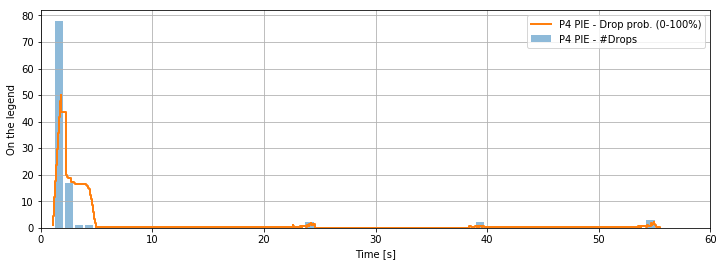

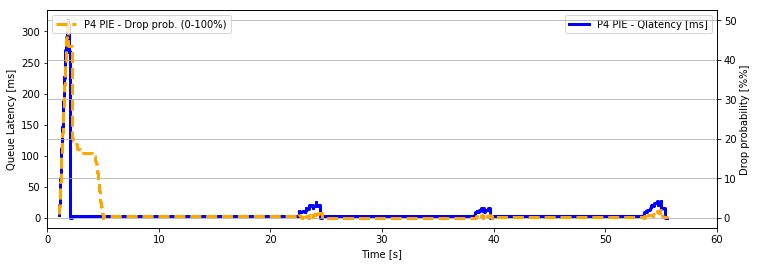

In [172]:
plot_drop_times_prob(['p4'],60,60)
plot_qdelay_drop_prob(['p4'],60)